# Data Loading

In [1]:
%matplotlib inline

import sqlite3
import pandas as pd
import numpy as np
import nltk
import string 
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer



# using the SQLite Table to read data.
con = sqlite3.connect('./amazon-fine-food-reviews/database.sqlite') 



#filtering only positive and negative reviews i.e. 
# not taking into consideration those reviews with Score=3
filtered_data = pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3
""", con) 




# Give reviews with Score>3 a positive rating, and reviews with a score<3 a negative rating.
def partition(x):
    if x < 3:
        return 'negative'
    return 'positive'

#changing reviews with score less than 3 to be positive and vice-versa
actualScore = filtered_data['Score']
positiveNegative = actualScore.map(partition) 
filtered_data['Score'] = positiveNegative

# Data Cleaning

In [2]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND UserId="AR5J8UI46CURR"
ORDER BY ProductID
""", con)

#Sorting data according to ProductId in ascending order
sorted_data=filtered_data.sort_values('ProductId', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')
#Deduplication of entries
final=sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)
final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]

# Data Pre-Processing

In [3]:
import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

stop = set(stopwords.words('english')) #set of stopwords
sno = nltk.stem.SnowballStemmer('english') #initialising the snowball stemmer

def cleanhtml(sentence): #function to clean the word of any html-tags
    cleanr = re.compile('<.*?>')
    cleantext = re.sub(cleanr, ' ', sentence)
    return cleantext
def cleanpunc(sentence): #function to clean the word of any punctuation or special characters
    cleaned = re.sub(r'[?|!|\'|"|#]',r'',sentence)
    cleaned = re.sub(r'[.|,|)|(|\|/]',r' ',cleaned)
    return  cleaned

In [4]:
#Code for implementing step-by-step the checks mentioned in the pre-processing phase
# this code takes a while to run as it needs to run on 500k sentences.
i=0
str1=' '
final_string=[]
all_positive_words=[] # store words from +ve reviews here
all_negative_words=[] # store words from -ve reviews here.
s=''
for sent in final['Text'].values:
    filtered_sentence=[]
    #print(sent);
    sent=cleanhtml(sent) # remove HTMl tags
    for w in sent.split():
        for cleaned_words in cleanpunc(w).split():
            if((cleaned_words.isalpha()) & (len(cleaned_words)>2)):    
                if(cleaned_words.lower() not in stop):
                    s=(sno.stem(cleaned_words.lower())).encode('utf8')
                    filtered_sentence.append(s)
                    if (final['Score'].values)[i] == 'positive': 
                        all_positive_words.append(s) #list of all words used to describe positive reviews
                    if(final['Score'].values)[i] == 'negative':
                        all_negative_words.append(s) #list of all words used to describe negative reviews reviews
                else:
                    continue
            else:
                continue 
    #print(filtered_sentence)
    str1 = b" ".join(filtered_sentence) #final string of cleaned words
    #print("***********************************************************************")
    
    final_string.append(str1)
    i+=1
final['CleanedText']=final_string #adding a column of CleanedText which displays the data after pre-processing of the review 


# Time Based Sorting

In [5]:
final=final.sort_values('Time', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

# Data Sampling

In [6]:
final = final.iloc[0:100000]
scores = final['Score']

# Split Dataset in to Train & Test

In [8]:
# ============================== loading libraries ===========================================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cross_validation import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.cross_validation import cross_val_score
from collections import Counter
from sklearn.metrics import accuracy_score
from sklearn import cross_validation
from sklearn.naive_bayes import BernoulliNB
import warnings
from sklearn.preprocessing import Imputer
# =============================================================================================z

warnings.filterwarnings("ignore") 

# split the data set into train and test
X_tr, X_test, y_tr, y_test = cross_validation.train_test_split(final['CleanedText'].values, scores, test_size=0.3, random_state=0)

y_test = y_test.values
y_tr = y_tr.values

# Featurization using BOW

In [34]:
#supress warnings
warnings.filterwarnings("ignore")

#Converting text to vector(BOW)
count_vect = CountVectorizer() #in scikit-learn
count_vect.fit(X_tr)
X_tr_vector_bow = count_vect.transform(X_tr)
X_test_vector_bow = count_vect.transform(X_test)

# Column Standardization

In [35]:
from sklearn.preprocessing import StandardScaler
warnings.filterwarnings("ignore")
scaler = StandardScaler(copy=True, with_mean=False, with_std=True)
scaler.fit(X_tr_vector_bow)
X_tr_vector_bow = scaler.transform(X_tr_vector_bow)
X_test_vector_bow =scaler.transform(X_test_vector_bow)

In [36]:
from sklearn.grid_search import GridSearchCV
from sklearn.grid_search import RandomizedSearchCV
from sklearn.svm import SVC
from sklearn.preprocessing import LabelEncoder


def findGridSearchCVBestParameters(x_tr,y_tr):
    parameters = {'gamma': [1e-6,1e-5,1e-4,1e-3,1e-2, 1e-1],'C': [1e-2,1e-1, 1, 1e2]}
    gridmodel = GridSearchCV(SVC(class_weight = "balanced"), param_grid=parameters,scoring = 'roc_auc', cv=5)
    lableEncoder = LabelEncoder()
    y_tr = lableEncoder.fit_transform(y_tr)
    gridmodel.fit(x_tr, y_tr)
    grid_best_params = gridmodel.best_estimator_
    gridmodel_best_score = gridmodel.best_score_
    return grid_best_params,gridmodel_best_score
    

In [37]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.preprocessing import LabelEncoder


def findRandomSearchCVBestParameters(x_tr,y_tr):
    parameters = {'gamma': [1e-6,1e-5,1e-4,1e-3,1e-2, 1e-1],'C': [1e-2,1e-1, 1, 1e2]}
    rand_search = RandomizedSearchCV(SVC(class_weight = "balanced"), param_distributions = parameters,cv = 5, scoring = 'roc_auc') 
    lableEncoder = LabelEncoder()
    y_tr = lableEncoder.fit_transform(y_tr)
    rand_search.fit(x_tr,y_tr)
    randomsearch_best_params = rand_search.best_estimator_
    randomsearch_best_score = rand_search.best_score_
    return randomsearch_best_params,randomsearch_best_score

# **Finding Optimal C and gamma using Grid ,Random Search**

In [14]:
randomsearch_best_params_bow,randomsearch_best_score_bow = findRandomSearchCVBestParameters(X_tr_vector_bow,y_tr)
gridsearch_best_params_bow,gridsearch_best_score_bow = findGridSearchCVBestParameters(X_tr_vector_bow,y_tr)

In [15]:
print('Grid Search Best Params:\n',gridsearch_best_params_bow)
print('Grid Search Best Score:\n',gridsearch_best_score_bow)
print('Random Search Best Params:\n',randomsearch_best_params_bow)
print('Random Search Best Score:\n',randomsearch_best_score_bow)

Grid Search Best Params:
 SVC(C=1, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=1e-05, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)
Grid Search Best Score:
 0.9027095264031507
Random Search Best Params:
 SVC(C=1, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=1e-05, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)
Random Search Best Score:
 0.9027095264031507


# **Train and Test Accuarcy with Optimal Parameters**

             precision    recall  f1-score   support

   negative       0.65      0.23      0.33       320
   positive       0.91      0.99      0.95      2680

avg / total       0.89      0.90      0.88      3000

Training accuracy: 0.9591428571428572
Test accuracy: 0.9046666666666666


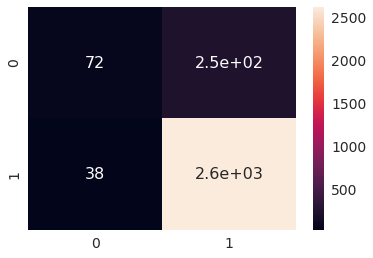

In [38]:
from sklearn.metrics import classification_report
import seaborn as sns
from sklearn.svm import SVC

classifier_bow = SVC(C=1,gamma=1e-05,class_weight="balanced")
classifier_bow.fit(X_tr_vector_bow, y_tr)
y_pred_bow = classifier_bow.predict(X_test_vector_bow)
print(classification_report(y_test, y_pred_bow))
print('Training accuracy:', classifier_bow.score(X_tr_vector_bow, y_tr))
print('Test accuracy:', classifier_bow.score(X_test_vector_bow, y_test))

confusion_matrix = confusion_matrix(y_test, y_pred_bow)
sns.set(font_scale=1.4)#for label size
sns.heatmap(confusion_matrix, annot=True,annot_kws={"size": 16})

# Plotting Train & Test Error

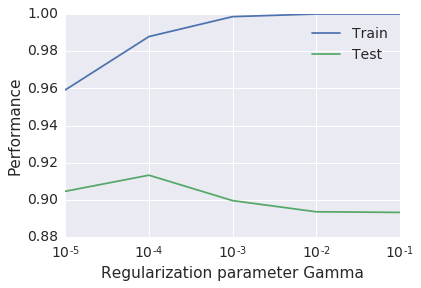

In [39]:
from sklearn.metrics import classification_report
import seaborn as sns
import matplotlib.pyplot as plt
gamma = [1e-1,1e-2,1e-3, 1e-4,1e-5]
train_errors = list()
test_errors = list()
for g in gamma:
    classifier = SVC(C=1,gamma=g,class_weight="balanced")
    classifier.fit(X_tr_vector_bow, y_tr)
    train_errors.append(classifier.score(X_tr_vector_bow, y_tr))
    test_errors.append(classifier.score(X_test_vector_bow, y_test))

plt.semilogx(gamma, train_errors, label='Train')
plt.semilogx(gamma, test_errors, label='Test')
plt.legend(loc='upper right')
plt.xlabel('Regularization parameter Gamma')
plt.ylabel('Performance')

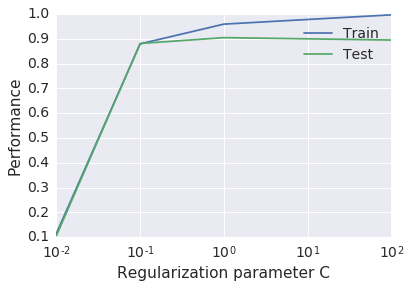

In [41]:
from sklearn.metrics import classification_report
import seaborn as sns
import matplotlib.pyplot as plt
C = [0.01,0.1,1,100]
train_errors = list()
test_errors = list()
for c in C:
    classifier = SVC(C=c,gamma=1e-05,class_weight="balanced")
    classifier.fit(X_tr_vector_bow, y_tr)
    train_errors.append(classifier.score(X_tr_vector_bow, y_tr))
    test_errors.append(classifier.score(X_test_vector_bow, y_test))

plt.semilogx(C, train_errors, label='Train')
plt.semilogx(C, test_errors, label='Test')
plt.legend(loc='upper right')
plt.xlabel('Regularization parameter C')
plt.ylabel('Performance')

# **SGDClassifier with Hinge Loss**

In [42]:
from sklearn import linear_model
sgdclf = linear_model.SGDClassifier(class_weight="balanced")
sgdclf.fit(X_tr_vector_bow, y_tr)
y_pred_bow = sgdclf.predict(X_test_vector_bow)
print(classification_report(y_test, y_pred_bow))
print('Training accuracy:', sgdclf.score(X_tr_vector_bow, y_tr))
print('Test accuracy:', sgdclf.score(X_test_vector_bow, y_test))

             precision    recall  f1-score   support

   negative       0.34      0.65      0.44       320
   positive       0.95      0.85      0.90      2680

avg / total       0.89      0.82      0.85      3000

Training accuracy: 0.9748571428571429
Test accuracy: 0.825


# Featurization using tfidf

In [10]:
#Converting text to tfidf vector(tfidf)
tf_idf_vect = TfidfVectorizer()
final_tf_idf = tf_idf_vect.fit(X_tr)
X_tr_vector_tfidf = final_tf_idf.transform(X_tr)
X_test_vector_tfidf = final_tf_idf.transform(X_test)

# Column Standardization

In [11]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler(copy=True, with_mean=False, with_std=True)
scaler.fit(X_tr_vector_tfidf)
X_tr_vector_tfidf = scaler.transform(X_tr_vector_tfidf)
X_test_vector_tfidf =scaler.transform(X_test_vector_tfidf)

# **Finding Optimal C and gamma using Grid ,Random Search**

In [22]:
randomsearch_best_params_tfidf,randomsearch_best_score_tfidf = findRandomSearchCVBestParameters(X_tr_vector_tfidf,y_tr)
gridsearch_best_params_tfidf,gridsearch_best_score_tfidf = findGridSearchCVBestParameters(X_tr_vector_tfidf,y_tr)

In [23]:
print('Grid Search Best Params',gridsearch_best_params_tfidf)
print('Grid Search Best Score',gridsearch_best_score_tfidf)
print('Random Search Best Params',randomsearch_best_params_tfidf)
print('Random Search Best Score',randomsearch_best_score_tfidf)

Grid Search Best Params SVC(C=1, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=1e-05, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)
Grid Search Best Score 0.9036021517508962
Random Search Best Params SVC(C=1, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=1e-05, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)
Random Search Best Score 0.9036021517508962


# Train and Test Accuarcy with Optimal Parameters

             precision    recall  f1-score   support

   negative       0.67      0.35      0.46       320
   positive       0.93      0.98      0.95      2680

avg / total       0.90      0.91      0.90      3000

Training accuracy: 0.978
Test accuracy: 0.9123333333333333


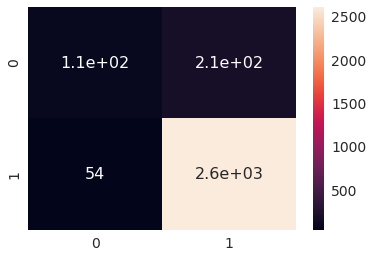

In [12]:
from sklearn.metrics import classification_report
from sklearn.svm import SVC

classifier_tfidf = SVC(C=1,gamma=1e-05,class_weight="balanced")
classifier_tfidf.fit(X_tr_vector_tfidf, y_tr)
y_pred_tfidf = classifier_tfidf.predict(X_test_vector_tfidf)
print(classification_report(y_test, y_pred_tfidf))
print('Training accuracy:', classifier_tfidf.score(X_tr_vector_tfidf, y_tr))
print('Test accuracy:', classifier_tfidf.score(X_test_vector_tfidf, y_test))

confusion_matrix = confusion_matrix(y_test, y_pred_tfidf)
sns.set(font_scale=1.4)#for label size
sns.heatmap(confusion_matrix, annot=True,annot_kws={"size": 16})

# Plotting Train & Test Error

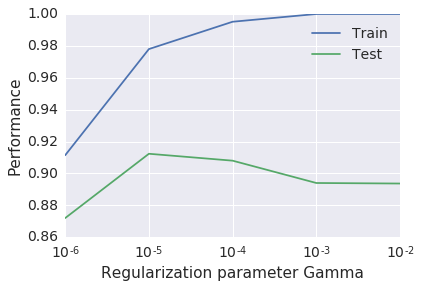

In [44]:
from sklearn.metrics import classification_report
import seaborn as sns
import matplotlib.pyplot as plt
gamma = [1e-2,1e-3,1e-4,1e-5,1e-6]
train_errors = list()
test_errors = list()
for g in gamma:
    classifier = SVC(C=1,gamma=g,class_weight="balanced")
    classifier.fit(X_tr_vector_tfidf, y_tr)
    train_errors.append(classifier.score(X_tr_vector_tfidf, y_tr))
    test_errors.append(classifier.score(X_test_vector_tfidf, y_test))

plt.semilogx(gamma, train_errors, label='Train')
plt.semilogx(gamma, test_errors, label='Test')
plt.legend(loc='upper right')
plt.xlabel('Regularization parameter Gamma')
plt.ylabel('Performance')

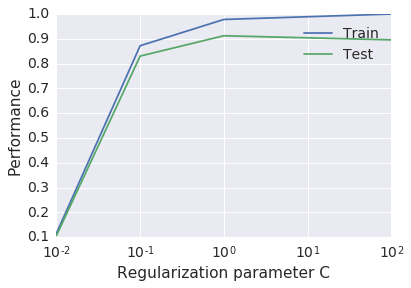

In [45]:
from sklearn.metrics import classification_report
import seaborn as sns
import matplotlib.pyplot as plt
C = [0.01,0.1,1,100]
train_errors = list()
test_errors = list()
for c in C:
    classifier = SVC(C=c,gamma=1e-05,class_weight="balanced")
    classifier.fit(X_tr_vector_tfidf, y_tr)
    train_errors.append(classifier.score(X_tr_vector_tfidf, y_tr))
    test_errors.append(classifier.score(X_test_vector_tfidf, y_test))

plt.semilogx(C, train_errors, label='Train')
plt.semilogx(C, test_errors, label='Test')
plt.legend(loc='upper right')
plt.xlabel('Regularization parameter C')
plt.ylabel('Performance')

# **SGDClassifier with Hinge Loss**

In [46]:
from sklearn import linear_model
sgdclf = linear_model.SGDClassifier(class_weight="balanced")
sgdclf.fit(X_tr_vector_tfidf, y_tr)
y_pred_bow = sgdclf.predict(X_test_vector_tfidf)
print(classification_report(y_test, y_pred_tfidf))
print('Training accuracy:', sgdclf.score(X_tr_vector_tfidf, y_tr))
print('Test accuracy:', sgdclf.score(X_test_vector_tfidf, y_test))

             precision    recall  f1-score   support

   negative       0.67      0.35      0.46       320
   positive       0.93      0.98      0.95      2680

avg / total       0.90      0.91      0.90      3000

Training accuracy: 0.987
Test accuracy: 0.825


# Featurization using avgW2Vec

In [14]:
import gensim
import warnings


warnings.filterwarnings("ignore") 
i=0
list_of_sent_X_tr=[]
for sent in X_tr:
    filtered_sentence=[]
    sent = sent.decode('utf-8')
    sent=cleanhtml(sent)
    for w in sent.split():
        for cleaned_words in cleanpunc(w).split():
            if(cleaned_words.isalpha()):    
                filtered_sentence.append(cleaned_words.lower())
            else:
                continue 
    list_of_sent_X_tr.append(filtered_sentence)

In [15]:
import gensim

#supress warnings
warnings.filterwarnings("ignore")

i=0
list_of_sent_X_test=[]
for sent in X_test:
    filtered_sentence=[]
    sent = sent.decode('utf-8')
    sent=cleanhtml(sent)
    for w in sent.split():
        for cleaned_words in cleanpunc(w).split():
            if(cleaned_words.isalpha()):    
                filtered_sentence.append(cleaned_words.lower())
            else:
                continue 
    list_of_sent_X_test.append(filtered_sentence)

In [16]:
w2v_model=gensim.models.Word2Vec(list_of_sent_X_tr,min_count=1,size=50, workers=4) 

In [17]:
# average Word2Vec
# compute average word2vec for each review.
sent_vectors_X_tr = []; # the avg-w2v for each sentence/review is stored in this list
for sent in list_of_sent_X_tr: # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        try:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
        except:
            pass
    sent_vec /= cnt_words
    sent_vectors_X_tr.append(sent_vec)

In [18]:
# average Word2Vec
# compute average word2vec for each review.
sent_vectors_X_test = []; # the avg-w2v for each sentence/review is stored in this list
for sent in list_of_sent_X_test: # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        try:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
        except:
            pass
    sent_vec /= cnt_words
    sent_vectors_X_test.append(sent_vec)

In [19]:
X_tr_vector_avgW2V = sent_vectors_X_tr
X_test_vector_avgW2V = sent_vectors_X_test 

# Column Standardization

In [18]:
from sklearn.preprocessing import Imputer
X_test_vector_avgW2V = Imputer().fit_transform(X_test_vector_avgW2V)

In [19]:
from sklearn.preprocessing import StandardScaler
warnings.filterwarnings("ignore")
scaler = StandardScaler(copy=True, with_mean=False, with_std=True)
scaler.fit(X_tr_vector_avgW2V)
X_tr_vector_avgW2V = scaler.transform(X_tr_vector_avgW2V)
X_test_vector_avgW2V =scaler.transform(X_test_vector_avgW2V)

# **Finding Optimal C and gamma using Grid ,Random Search**

In [22]:
randomsearch_best_params_avgW2V,randomsearch_best_score_avgW2V = findRandomSearchCVBestParameters(X_tr_vector_avgW2V,y_tr)
gridsearch_best_params_avgW2V,gridsearch_best_score_avgW2V = findGridSearchCVBestParameters(X_tr_vector_avgW2V,y_tr)

In [31]:
print('Grid Search Best Params',gridsearch_best_params_avgW2V)
print('Grid Search Best Score',gridsearch_best_score_avgW2V)
print('Random Search Best Params',randomsearch_best_params_avgW2V)
print('Random Search Best Score',randomsearch_best_score_avgW2V)

Grid Search Best Params SVC(C=100.0, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.001, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)
Grid Search Best Score 0.8327741483672214
Random Search Best Params SVC(C=100.0, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.001, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)
Random Search Best Score 0.8327741483672214


# Train and Test Accuarcy with Optimal Parameters

             precision    recall  f1-score   support

   negative       0.26      0.78      0.39       320
   positive       0.97      0.74      0.83      2680

avg / total       0.89      0.74      0.79      3000

Training accuracy: 0.7477142857142857
Test accuracy: 0.7396666666666667


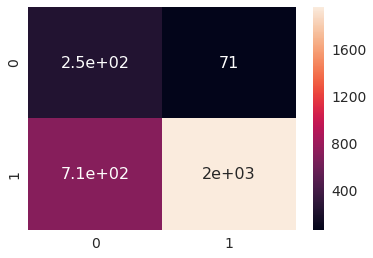

In [20]:
from sklearn.metrics import classification_report
import seaborn as sns
from sklearn.svm import SVC
classifier_avgW2V = SVC(C=100,gamma=0.001,class_weight="balanced")
classifier_avgW2V.fit(X_tr_vector_avgW2V, y_tr)
y_pred_avgW2V = classifier_avgW2V.predict(X_test_vector_avgW2V)
print(classification_report(y_test, y_pred_avgW2V))
print('Training accuracy:', classifier_avgW2V.score(X_tr_vector_avgW2V, y_tr))
print('Test accuracy:', classifier_avgW2V.score(X_test_vector_avgW2V, y_test))


confusion_matrix = confusion_matrix(y_test, y_pred_avgW2V)
sns.set(font_scale=1.4)#for label size
sns.heatmap(confusion_matrix, annot=True,annot_kws={"size": 16})



# Plotting Train & Test Error

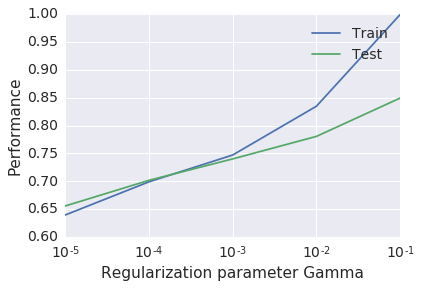

In [48]:
from sklearn.metrics import classification_report
import seaborn as sns
import matplotlib.pyplot as plt
gamma = [1e-1,1e-2,1e-3, 1e-4,1e-5]
train_errors = list()
test_errors = list()
for g in gamma:
    classifier = SVC(C=100,gamma=g,class_weight="balanced")
    classifier.fit(X_tr_vector_avgW2V, y_tr)
    train_errors.append(classifier.score(X_tr_vector_avgW2V, y_tr))
    test_errors.append(classifier.score(X_test_vector_avgW2V, y_test))

plt.semilogx(gamma, train_errors, label='Train')
plt.semilogx(gamma, test_errors, label='Test')
plt.legend(loc='upper right')
plt.xlabel('Regularization parameter Gamma')
plt.ylabel('Performance')

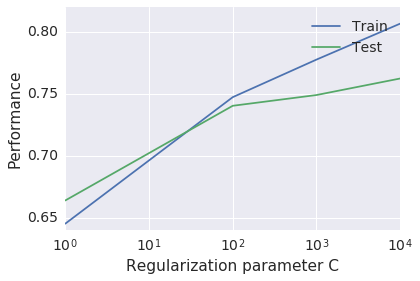

In [49]:
from sklearn.metrics import classification_report
import seaborn as sns
import matplotlib.pyplot as plt
C = [1,100,1000,10000]
train_errors = list()
test_errors = list()
for c in C:
    classifier = SVC(C=c,gamma=0.001,class_weight="balanced")
    classifier.fit(X_tr_vector_avgW2V, y_tr)
    train_errors.append(classifier.score(X_tr_vector_avgW2V, y_tr))
    test_errors.append(classifier.score(X_test_vector_avgW2V, y_test))

plt.semilogx(C, train_errors, label='Train')
plt.semilogx(C, test_errors, label='Test')
plt.legend(loc='upper right')
plt.xlabel('Regularization parameter C')
plt.ylabel('Performance')

# **SGDClassifier with Hinge Loss**

In [55]:
from sklearn import linear_model
sgdclf = linear_model.SGDClassifier(class_weight="balanced")
sgdclf.fit(X_tr_vector_avgW2V, y_tr)
y_pred_avgW2V = sgdclf.predict(X_test_vector_avgW2V)
print(classification_report(y_test, y_pred_avgW2V))
print('Training accuracy:', sgdclf.score(X_tr_vector_avgW2V, y_tr))
print('Test accuracy:', sgdclf.score(X_test_vector_avgW2V, y_test))

             precision    recall  f1-score   support

   negative       0.36      0.38      0.37       320
   positive       0.92      0.92      0.92      2680

avg / total       0.86      0.86      0.86      3000

Training accuracy: 0.8598571428571429
Test accuracy: 0.8616666666666667


# Featurization using tfidfw2v

In [12]:
tf_idf_X_tr_vect = TfidfVectorizer()
tf_idf_X_tr_vect.fit(X_tr)
final_tf_idf_X_tr_vect = tf_idf_X_tr_vect.transform(X_tr)
final_tf_idf_X_test_vect = tf_idf_X_tr_vect.transform(X_test)

In [20]:
# TF-IDF weighted Word2Vec
tfidf_feat = tf_idf_X_tr_vect.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_sent_X_tr_vectors = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in list_of_sent_X_tr: # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        try: 
            
            vec = w2v_model.wv[word]
            # obtain the tf_idfidf of a word in a sentence/review
            tf_idf = final_tf_idf_X_tr_vect[row, tfidf_feat.index(word)]
            sent_vec +=(vec * tf_idf)
            weight_sum += tf_idf
        except:
            pass
    sent_vec /= weight_sum
    tfidf_sent_X_tr_vectors.append(sent_vec)
    row += 1

In [21]:
# TF-IDF weighted Word2Vec
tfidf_feat = tf_idf_X_tr_vect.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_sent_X_test_vectors = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in list_of_sent_X_test: # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        try:
            
            vec = w2v_model.wv[word]
            # obtain the tf_idfidf of a word in a sentence/review
            tf_idf = final_tf_idf_X_test_vect[row, tfidf_feat.index(word)]
            sent_vec +=(vec * tf_idf)
            weight_sum += tf_idf
        except:
            pass
    sent_vec /= weight_sum
    tfidf_sent_X_test_vectors.append(sent_vec)
    row += 1

In [22]:
X_tr_vector_tfidfW2V = tfidf_sent_X_tr_vectors
X_test_vector_tfidfW2V = tfidf_sent_X_test_vectors

# Column Standardization

In [23]:
from sklearn.preprocessing import Imputer
X_tr_vector = Imputer().fit_transform(X_tr_vector_tfidfW2V)
X_test_vector = Imputer().fit_transform(X_test_vector_tfidfW2V)

In [24]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler(copy=True, with_mean=False, with_std=True)
scaler.fit(X_tr_vector_tfidfW2V)
X_tr_vector_tfidfW2V = scaler.transform(X_tr_vector_tfidfW2V)
X_test_vector_tfidfW2V =scaler.transform(X_test_vector_tfidfW2V)

# **Finding Optimal C and gamma using Grid ,Random Search**

In [29]:
randomsearch_best_params_tfidfW2V,randomsearch_best_score_tfidfW2V = findRandomSearchCVBestParameters(X_tr_vector_tfidfW2V,y_tr)
gridsearch_best_params_tfidfW2V,gridsearch_best_score_tfidfW2V = findGridSearchCVBestParameters(X_tr_vector_tfidfW2V,y_tr)

In [30]:
print('Grid Search Best Params',gridsearch_best_params_tfidfW2V)
print('Grid Search Best Score',gridsearch_best_score_tfidfW2V)
print('Random Search Best Params',randomsearch_best_params_tfidfW2V)
print('Random Search Best Score',randomsearch_best_score_tfidfW2V)

Grid Search Best Params SVC(C=100.0, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.001, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)
Grid Search Best Score 0.8050209908231113
Random Search Best Params SVC(C=100.0, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.001, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)
Random Search Best Score 0.8050209908231113


# Train and Test Accuarcy with Optimal Parameters

             precision    recall  f1-score   support

   negative       0.23      0.78      0.36       320
   positive       0.96      0.70      0.81      2680

avg / total       0.89      0.71      0.76      3000

Training accuracy: 0.7048571428571428
Test accuracy: 0.7063333333333334


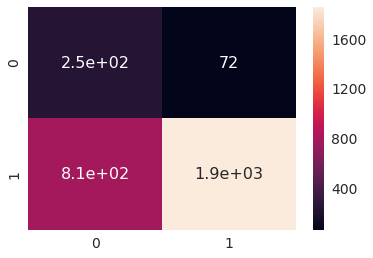

In [25]:
from sklearn.metrics import classification_report
from sklearn.svm import SVC
classifier_tfidfW2V = SVC(C=100,gamma=0.001,class_weight="balanced")
classifier_tfidfW2V.fit(X_tr_vector_tfidfW2V, y_tr)
y_pred_tfidfW2V = classifier_tfidfW2V.predict(X_test_vector_tfidfW2V)
print(classification_report(y_test, y_pred_tfidfW2V))
print('Training accuracy:', classifier_tfidfW2V.score(X_tr_vector_tfidfW2V, y_tr))
print('Test accuracy:', classifier_tfidfW2V.score(X_test_vector_tfidfW2V, y_test))


confusion_matrix = confusion_matrix(y_test, y_pred_tfidfW2V)
sns.set(font_scale=1.4)#for label size
sns.heatmap(confusion_matrix, annot=True,annot_kws={"size": 16})


# Plotting Train & Test Error

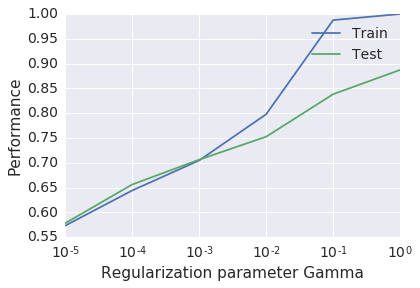

In [26]:
from sklearn.metrics import classification_report
import seaborn as sns
import matplotlib.pyplot as plt
gamma = [1,1e-1,1e-2,1e-3, 1e-4,1e-5]
train_errors = list()
test_errors = list()
for g in gamma:
    classifier = SVC(C=100,gamma=g,class_weight="balanced")
    classifier.fit(X_tr_vector_tfidfW2V, y_tr)
    train_errors.append(classifier.score(X_tr_vector_tfidfW2V, y_tr))
    test_errors.append(classifier.score(X_test_vector_tfidfW2V, y_test))

plt.semilogx(gamma, train_errors, label='Train')
plt.semilogx(gamma, test_errors, label='Test')
plt.legend(loc='upper right')
plt.xlabel('Regularization parameter Gamma')
plt.ylabel('Performance')

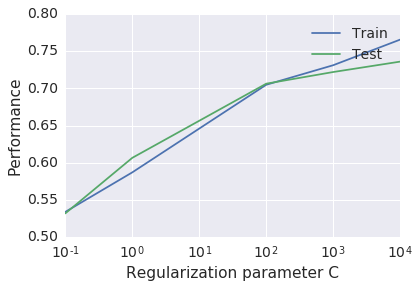

In [27]:
from sklearn.metrics import classification_report
import seaborn as sns
import matplotlib.pyplot as plt
C = [0.1,1,100,1000,10000]
train_errors = list()
test_errors = list()
for c in C:
    classifier = SVC(C=c,gamma=0.001,class_weight="balanced")
    classifier.fit(X_tr_vector_tfidfW2V, y_tr)
    train_errors.append(classifier.score(X_tr_vector_tfidfW2V, y_tr))
    test_errors.append(classifier.score(X_test_vector_tfidfW2V, y_test))

plt.semilogx(C, train_errors, label='Train')
plt.semilogx(C, test_errors, label='Test')
plt.legend(loc='upper right')
plt.xlabel('Regularization parameter C')
plt.ylabel('Performance')

# **SGDClassifier with Hinge Loss**

In [29]:
from sklearn import linear_model
sgdclf = linear_model.SGDClassifier(class_weight="balanced")
sgdclf.fit(X_tr_vector_tfidfW2V, y_tr)
y_pred_tfidfW2V = sgdclf.predict(X_test_vector_tfidfW2V)
print(classification_report(y_test, y_pred_tfidfW2V))
print('Training accuracy:', sgdclf.score(X_tr_vector_tfidfW2V, y_tr))
print('Test accuracy:', sgdclf.score(X_test_vector_tfidfW2V, y_test))

             precision    recall  f1-score   support

   negative       0.32      0.32      0.32       320
   positive       0.92      0.92      0.92      2680

avg / total       0.85      0.86      0.85      3000

Training accuracy: 0.8521428571428571
Test accuracy: 0.8553333333333333


# Conclusion

In [12]:
from prettytable import PrettyTable
t = PrettyTable()
t.field_names = ['Featurization', 'Optimal C','Optimal gamma','TrainError','TestError']
t.add_row(["BOW","1","1e-05","0.04085714285","0.09533333333"])
t.add_row(["TFIDF","1","1e-05","0.022","0.08766666666"])
t.add_row(["AVGW2Vec","100","0.001","0.25228571428","0.26033333333"])
t.add_row(["TFIDFW2Vec","100","0.001","0.29514285714","0.29366666666"])
print(t)
t1 = PrettyTable()
print('***SGDClassifier with Hingeloss***')
t1.field_names = ['Featurization','HingelossTrainError','HingelossTestError']
t1.add_row(["BOW","0.02514285714","0.175"])
t1.add_row(["TFIDF","0.013","0.175"])
t1.add_row(["AVGW2Vec","0.14014285714","0.13833333333"])
t1.add_row(["TFIDFW2Vec","0.14785714285","0.14466666666"])
print(t1)

+---------------+-----------+---------------+---------------+---------------+
| Featurization | Optimal C | Optimal gamma |   TrainError  |   TestError   |
+---------------+-----------+---------------+---------------+---------------+
|      BOW      |     1     |     1e-05     | 0.04085714285 | 0.09533333333 |
|     TFIDF     |     1     |     1e-05     |     0.022     | 0.08766666666 |
|    AVGW2Vec   |    100    |     0.001     | 0.25228571428 | 0.26033333333 |
|   TFIDFW2Vec  |    100    |     0.001     | 0.29514285714 | 0.29366666666 |
+---------------+-----------+---------------+---------------+---------------+
***SGDClassifier with Hingeloss***
+---------------+---------------------+--------------------+
| Featurization | HingelossTrainError | HingelossTestError |
+---------------+---------------------+--------------------+
|      BOW      |    0.02514285714    |       0.175        |
|     TFIDF     |        0.013        |       0.175        |
|    AVGW2Vec   |    0.14014285714  